# Transfer learning

Das Ziel des Transferlearning ist es, ein bereits trainiertes Modell auf eine andere Aufgabe zu trainieren. Die Idee dahinter ist den Teil des Netzwerks, der für die Extraktion von Merkmalen zuständig ist, zu "recyceln". Da dies in der Regel der teuerste Teil des Trainings ist, spart man sich dadurch eine Menge an Zeit. Das bedeutet, dass dieser Teil nicht neu trainiert werden muss, sondern die bereits trainierte Featurextraktion genauso gut für eine ähnliche Aufgabe verwendet werden kann. Aus diesem Grund sollte man ein bereits trainiertes Netzwerk nutzen, welches für eine ähnliche Aufgabe trainiert wurde. Lediglich die Klassifikationsschicht wird neu trainiert. Ziel dieses Notebooks ist es, ein Verständnis zu bekommen, was beim Transferlearning passiert.

Schauen Sie sich folgendes Notebook an und versuchen Sie den groben Ablauf zu verstehen.
Sie werden die meisten Befehle die Sie benötigen darin finden.
https://www.tensorflow.org/tutorials/images/transfer_learning

Für diese Aufgabe wollen wir das in der letzten Aufgabe trainierte Convolutional Neural Network, welches auf dem Mnist Datensatz trainiert wurde, auf eine andere Aufgabe trainieren. Die Aufgabe des Netzwerks soll es sein, Hexadezimalzahlen zu erkennen.
Hierzu verwenden wir den $\textit{emnist}$ Datensatz. Dieser beinhaltet zusätzlich das Alphabet (große und kleine Buchstaben). Näheres dazu unter https://pypi.org/project/emnist/ 

Gehen Sie dazu wie folgt vor:

    * Laden Sie ihr Modell aus der vorherigen Aufgabe mit tf.keras.models.load_model("Name des Modells") Falls Sie ihr Modell nicht gespeichert hatten, können Sie dies mit model.save("Name des Modells"), nachdem Sie erneut trainiert haben, tun.
      
    * Bereiten Sie den emnist-Datensatz wie in der vorherigen Aufgabe vor und sortieren Sie alle Kleinbuchstaben sowie alle Buchstaben, die nicht der Hexadezimalschreibweise angehören, aus!
      
    * Laden Sie das zuvor gespeicherte Modell und entfernen Sie die letzte Schicht ( model.pop() )
    
    * Frieren Sie das Modell ein, d.h. Sie setzen die Layer auf nicht trainierbar
    
    * Fügen Sie eine neue Schicht hinzu, sodass die verschiedenen Klassen (0-F) klassifiziert werden können (Wir beschränken uns hier auf die groß geschriebenen Buchstaben)
    
    * Trainieren Sie das Netzwerk mit den transformierten Labels
    
    * Plotten Sie wieder die Trainingskurven und erstellen sie eine confusion Matrix

In [1]:
import matplotlib.pyplot as plt
import keras
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix 
from extra_keras_datasets import emnist

## Laden der Emnist Daten

In [2]:
(input_train, target_train), (input_test, target_test) = emnist.load_data(type='balanced')

INFO:root:Loading dataset = emnist


743900280/743900280 [==============================] - 119s 0us/step


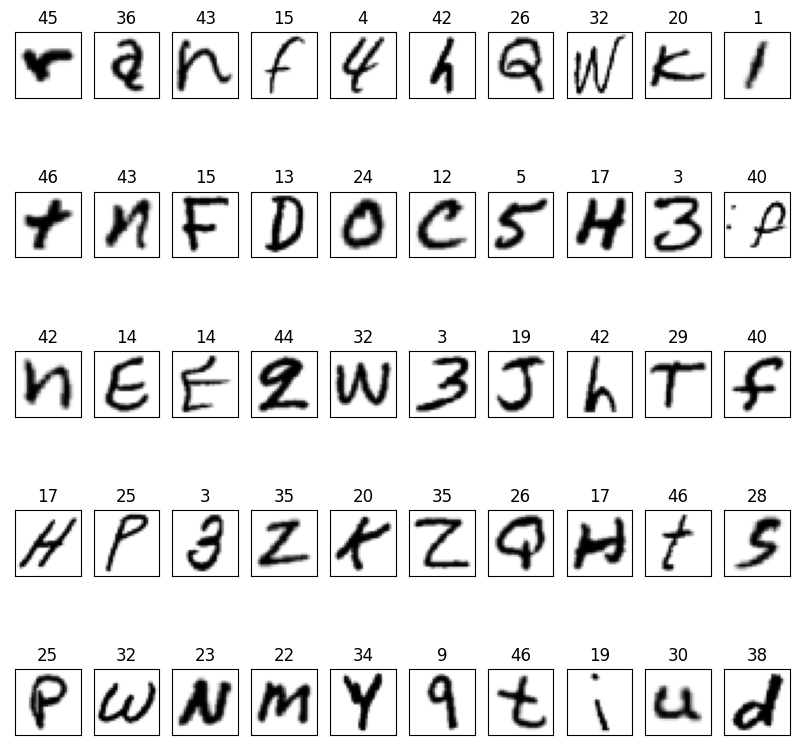

In [3]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(input_train[i], cmap=plt.cm.binary)
    plt.title(target_train[i])

## Vorbereiten der Emnist Daten

In [4]:
input_train = input_train[np.where(target_train < 16)]
target_train = target_train[np.where(target_train < 16)]
input_test = input_test[np.where(target_test < 16)]
target_test = target_test[np.where(target_test < 16)]

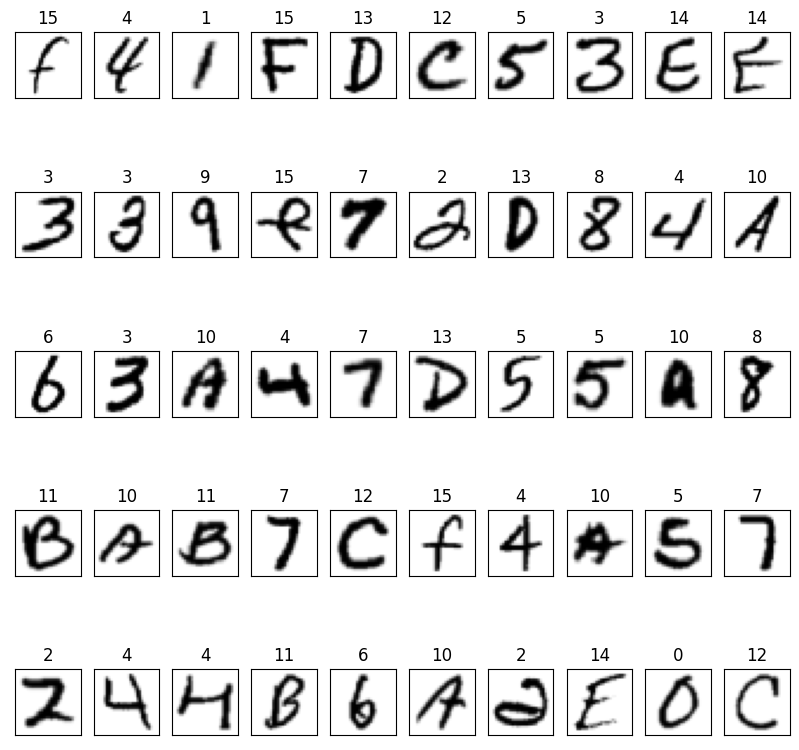

In [5]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(input_train[i], cmap=plt.cm.binary)
    plt.title(target_train[i])

In [6]:
# separate x_train in X_train and X_val, same for y_train
Input_train=input_train[0:30000] / 255 #divide by 255 so that they are in range 0 to 1
Target_train=keras.utils.to_categorical(target_train[0:30000],16) # one-hot encoding

Input_val=input_train[30000:38000] / 255
Target_val=keras.utils.to_categorical(target_train[30000:38000],16)

Input_test=input_test / 255
Target_test=keras.utils.to_categorical(target_test,16)

# del x_train, y_train, x_test, y_test

Input_train=np.reshape(Input_train, (Input_train.shape[0],28,28,1))
Input_val=np.reshape(Input_val, (Input_val.shape[0],28,28,1))
Input_test=np.reshape(Input_test, (Input_test.shape[0],28,28,1))


## Laden und anpassen des CNN aus der letzten Aufgabe

In [7]:
# Laden des Modells
base_model = tf.keras.models.load_model("cnn_model_exercise_5.h5")

base_model.summary()
#Hier die letzte Schicht entfernen
base_model.pop()
base_model.pop()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_6 (Dense)             (None, 10)               

In [8]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
Total params: 18,816
Trainable params: 18,816
Non-trai

In [9]:
# Modell einfrieren
base_model.trainable = False

# Basismodell als Ausgangspunkt nehmen
inputs = tf.keras.Input(shape=(28, 28,1))
x = base_model(inputs, training=False)

# Hier einen Dense-layer und einmal Softmax hinzufügen, sodass die verschiedenen Klassen vorhergesagt werden! können!
last_layer = tf.keras.layers.Dense(16, activation='softmax')(x)
output     = tf.keras.layers.Activation('softmax')(last_layer)

# Modell Zusammenfügen
model = tf.keras.Model(inputs, output)

In [15]:
# Modell Kompilieren, Kostenfunktion categorical_crossentropy, Optimizer Adam
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 1600)              18816     
                                                                 
 dense (Dense)               (None, 16)                25616     
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
Total params: 44,432
Trainable params: 25,616
Non-trainable params: 18,816
_________________________________________________________________


In [16]:
# Accuracy vor dem Transferlearning bestimmen
loss0, accuracy0 = model.evaluate(x = Input_test,y = Target_test)

200/200 [==============================] - 0s 2ms/step - loss: 1.9200 - accuracy: 0.9663


In [17]:
# Hier das Netzwerk für 10 Epochen trainieren!
history = model.fit(
    Input_train,
    Target_train,
    epochs=10,
    validation_data=(Input_val, Target_val),
)

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 1.9184 - accuracy: 0.9645 - val_loss: 1.9201 - val_accuracy: 0.9614
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 1.9083 - accuracy: 0.9713 - val_loss: 1.9167 - val_accuracy: 0.9622
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 1.9036 - accuracy: 0.9749 - val_loss: 1.9166 - val_accuracy: 0.9601
Epoch 4/10
938/938 [==============================] - 2s 3ms/step - loss: 1.9005 - accuracy: 0.9782 - val_loss: 1.9165 - val_accuracy: 0.9614
Epoch 5/10
938/938 [==============================] - 2s 3ms/step - loss: 1.8987 - accuracy: 0.9790 - val_loss: 1.9139 - val_accuracy: 0.9631
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 1.8956 - accuracy: 0.9817 - val_loss: 1.9118 - val_accuracy: 0.9647
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 1.8947 - accuracy: 0.9827 - val_loss: 1.9125 - val_accuracy: 0.9634
Epoch 

## Plotten der Ergebnisse

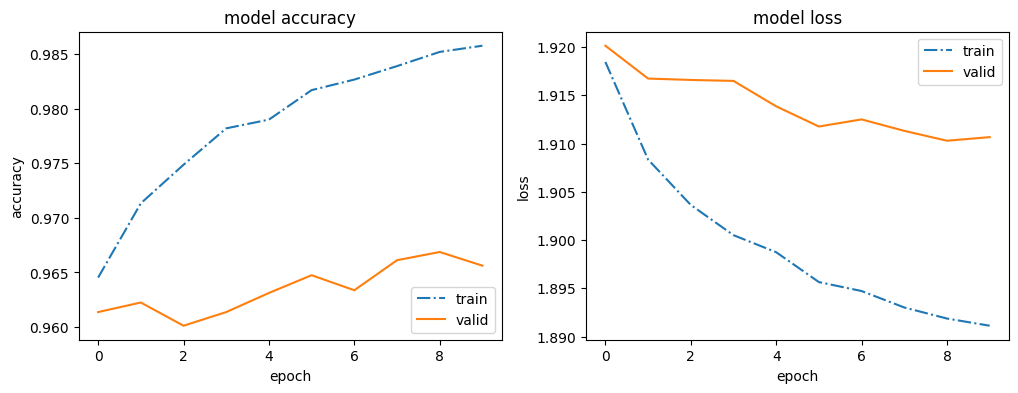

In [20]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [19]:
# Confusion Matrix erstellen
predictions = model.predict(Input_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(Target_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)
acc_fc_orig = np.sum(np.argmax(Target_test,axis=1)==np.argmax(predictions,axis=1))/len(predictions)
print("Acc_fc_orig_flat = " , acc_fc_orig)


200/200 [==============================] - 0s 2ms/step
[[385   0   0   0   1   0   2   0   0   0   0   0   2  10   0   0]
 [  0 393   1   0   4   0   1   0   0   0   0   0   0   1   0   0]
 [  2   1 385   1   0   0   1   1   3   0   2   0   0   3   0   1]
 [  1   0   0 391   0   6   0   0   1   1   0   0   0   0   0   0]
 [  1   0   0   0 390   0   1   0   0   4   1   1   0   1   0   1]
 [  1   0   0   1   0 388   2   0   1   3   0   0   1   0   1   2]
 [  0   0   0   0   0   1 399   0   0   0   0   0   0   0   0   0]
 [  1   0   1   2   0   0   0 394   0   0   0   0   0   1   0   1]
 [  0   0   0   0   1   1   0   0 390   1   1   2   0   1   2   1]
 [  2   0   0   1   6   1   0   5   0 384   0   0   0   0   0   1]
 [  2   0   0   0   9   0   1   0   0   0 387   0   0   1   0   0]
 [  3   0   0   0   0   1   2   1   6   0   3 381   0   0   3   0]
 [  5   0   1   0   0   0   8   0   0   0   0   1 381   0   4   0]
 [ 30   0   2   2   1   1   0   1   2   0   0   2   0 358   1   0]
 [  0  